<h1><center>It’s Time to Make Some Crazy Money!</center></h1>
<h1><center>Predicting a NYC Taxi Trip Duration</center></h1>
*****

## Table of contents
1. [Modeling](#modeling)
    1. [Split Data](#split)
    2. [Scale data](#scale)
    3. [RMSLE](#metric)
    4. [Linear Regression](#linear)
    5. [Support Vector Machine](#svm)
    6. [Random Forest](#rforest)
    7. [XGBoost](#xgboost)
    8. [Tuning XGBoost](#tuning)
2. [Conclusion](#conclusion)
    1. [Results](#results)
    2. [Recommendations](#recommendations)

### Loading libraries <a name="libraries"></a>
***
These are some of the libraries used for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

### Loading data <a name="acquire"></a>
***
The data was acquired from a Kaggle's Competition called [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration). The data has been previously [cleaned](https://github.com/emmpew/datascience/blob/master/capstone_project/data_cleaning.ipynb) and is ready for modeling.

In [2]:
train = pd.read_csv('cleaned_train_data.csv')
test = pd.read_csv('cleaned_test_data.csv')

### Data content <a name="content"></a>
***
Let's look at the content of the data such as shape, columns, and summary statistics. 

In [3]:
train.head()

,Unnamed: 0,Unnamed: 0.1,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_flag_Y,pickup_month,pickup_hour,direct_distance,pickup_weekday
0,0,0.0,2.0,1.0,-73.98215,40.76794,-73.96463,40.76560,455.0,0.0,3.0,17.0,0.933406,0.0
1,1,1.0,1.0,1.0,-73.98042,40.73856,-73.99948,40.73115,663.0,0.0,6.0,0.0,1.123849,6.0
2,2,2.0,2.0,1.0,-73.97903,40.76394,-74.00533,40.71009,2124.0,0.0,1.0,11.0,3.964154,1.0
3,3,3.0,2.0,1.0,-74.01004,40.71997,-74.01227,40.70672,429.0,0.0,4.0,19.0,0.921886,2.0
4,4,4.0,2.0,1.0,-73.97305,40.79321,-73.97292,40.78252,435.0,0.0,3.0,13.0,0.737591,5.0


In [4]:
train.shape

(1450268, 14)

In [5]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'vendor_id', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'store_and_fwd_flag_Y',
       'pickup_month', 'pickup_hour', 'direct_distance', 'pickup_weekday'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450268 entries, 0 to 1450267
Data columns (total 14 columns):
Unnamed: 0              1450268 non-null int64
Unnamed: 0.1            1450268 non-null float64
vendor_id               1450268 non-null float64
passenger_count         1450268 non-null float64
pickup_longitude        1450268 non-null float64
pickup_latitude         1450268 non-null float64
dropoff_longitude       1450268 non-null float64
dropoff_latitude        1450268 non-null float64
trip_duration           1450268 non-null float64
store_and_fwd_flag_Y    1450268 non-null float64
pickup_month            1450268 non-null float64
pickup_hour             1450268 non-null float64
direct_distance         1450268 non-null float64
pickup_weekday          1450268 non-null float64
dtypes: float64(13), int64(1)
memory usage: 154.9 MB


# 1. Modeling <a name='modeling'></a>
***
Now after cleaning the data, let's use the training dataset to train the model. 

### Split Data  <a name='split'></a>
***
Now that the test dataset is ready let's split the data.

In [7]:
X_train = train.drop('trip_duration',axis=1)
y_train = train['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=102)

### Scaling Data <a name='scale'></a>
***
Let's scale the data in a range from 0 to 1.

In [8]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.fit_transform(X_train) 
# X_test_scaled = scaler.fit_transform(X_test)

### RMSLE <a name='metric'></a>
***
Metrics used to evaluate models are problem specific. In this case, [Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError) is the metric required for this problem. So the goal is to minimize the RMSLE.

In [9]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

### Linear regression <a name='linear'></a>
***
The goal with linear regression is to minimize the vertical distance between all the data points and the regression line. So in determining the best line, we are attempting to minimize the distance between all the points and their distance to the regression line.

Let's use linear regression to have a baseline of a model and from there implement other models that reduce the error. GridSearchCV will allow us to do cross validation and hyperparameter tuning at the same time. The following parameters will be tuned:

- fit_intercept: wheter to calculate the intercept for this model, meaning that if False, the intercept $\beta_0$ from our linear regression equation will be 0.
- normalize: to normalize the data before regression

In [10]:
params = {'fit_intercept':[True,False], 'normalize':[True,False]}

linreg_cv = GridSearchCV(LinearRegression(),params, cv=5)
%time linreg_cv.fit(X_train,y_train)

CPU times: user 18 s, sys: 4.73 s, total: 22.8 s
Wall time: 16.2 s


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
%time y_pred = linreg_cv.predict(X_test)

print("Best Parameters: {}".format(linreg_cv.best_params_)) 

CPU times: user 36.1 ms, sys: 26 ms, total: 62 ms
Wall time: 78.2 ms
Best Parameters: {'fit_intercept': True, 'normalize': False}
Best score is 0.6131640434846093


In [12]:
rmsle(y_test,y_pred)

/Users/andrew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


0.5397417884235575

In [13]:
print("Model R-Squared: {:.2f}%".format(100*linreg_cv.score(X_test, y_test)))

Model R-Squared: 55.79%


With one of the simplest linear models, the baseline rmsle is **0.5397**. $R^2$ is the percentage of the response variable variation that is explained by a linear model. In general, the higher the R-squared, the better the model fits your data. So the linear regression model explains **55.79%** of the variability of the response data around its mean. Now it is time to implement a more complex model such as Support Vector Machine. 

### SVM <a name='svm'></a>
***
Support Vector Machines are supervised learning models with associated learning algorithms that analyze data and recognize patterns. It can be used for both regression and classification; however, in this case, we will use it for regression. 

Let's use LinearSVR since it scales to large number of samples. First, create a pipeline and scale the data before using the SVM model. GridSearchCV will allow us to do cross validation and hyperparameter tuning at the same time. The following parameters will be tuned: 

- c: slack variable which allows the decision boundary to have some slack, meaning the model allows some misclassification. If we make c really small, we introduce more slack and get a more stable decision hyperplane. For regression, the influence of c is similar. You get less support vectors and get a smoother prediction. The slack variable allows for regression errors.

In [14]:
steps = [('scaler', StandardScaler()),
         ('svr', LinearSVR())]

pipeline = Pipeline(steps)

params = {'svr__C':[0.1,1,10]}

svr_cv = GridSearchCV(pipeline,params,cv=5,verbose=3)

In [15]:
%time svr_cv.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] svr__C=0.1 ......................................................
[CV] ............. svr__C=0.1, score=0.6003053797518216, total=   2.0s
[CV] svr__C=0.1 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ............. svr__C=0.1, score=0.5961437680743831, total=   2.5s
[CV] svr__C=0.1 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] ............. svr__C=0.1, score=0.5902271852026608, total=   2.6s
[CV] svr__C=0.1 ......................................................
[CV] ............. svr__C=0.1, score=0.5955791402350598, total=   2.2s
[CV] svr__C=0.1 ......................................................
[CV] ............. svr__C=0.1, score=0.6010509508008012, total=   2.2s
[CV] svr__C=1 ........................................................
[CV] ............... svr__C=1, score=0.6002570065375781, total=   3.1s
[CV] svr__C=1 ........................................................
[CV] ............... svr__C=1, score=0.5961128905325311, total=   3.1s
[CV] svr__C=1 ........................................................
[CV] ............... svr__C=1, score=0.5904125583663745, total=   3.2s
[CV] svr__C=1 ........................................................
[CV] ............... svr__C=1, score=0.5956627798078467, total=   4.4s
[CV] svr__C=1 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


CPU times: user 1min 34s, sys: 6.56 s, total: 1min 40s
Wall time: 1min 44s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=3)

In [16]:
%time y_pred = svr_cv.predict(X_test)

CPU times: user 79.7 ms, sys: 51.8 ms, total: 131 ms
Wall time: 117 ms


In [17]:
print("Best Parameters: {}".format(svr_cv.best_params_)) 

Best Parameters: {'svr__C': 1}
Best score is 0.5967386387700826


In [18]:
rmsle(y_test,y_pred)

/Users/andrew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


0.4899128923052467

In [19]:
print("Model R-Squared: {:.2f}%".format(100*svr_cv.score(X_test, y_test)))

Model R-Squared: 50.38%


With a value of **0.4899**, RMSLE decreased compared to linear regression which is our main goal. It is also important to mention that the model $R^2$ decreased to **50.38%**. The best slack value is 1.0. Now let's move on to more powerful and popular machine learning algorithms, ensemble methods. 

### Random Forest <a name='rforest'></a>
***
Random Forest generates bootstrap training samples (sample with replacement from the data set), and for each one it creates a tree. However, it doesn't just randomize the training samples, it also randomizes a set of predictors allowed to use each time a split is considered which is called bagging. It is harder to interpret but the predictive accuracy tends to be a lot better than compared to doing it just for one tree and superior to other methods as well.

Let's use RandomForestRegressor combined with GridSearchCV will allow us to do cross validation and hyperparameter tuning at the same time. The following parameters will be tuned:

- max_features: the number of features to consider when looking for the best split. Usually the default works so for simplicity let's use only 'auto'.
- n_estimators: The number of trees in the forest. Let's use lower number of trees due to the large amount of data. 

In [20]:
params = {'max_features': ['auto'],
          'n_estimators': [20, 30, 40, 50]}

forest_cv = GridSearchCV(RandomForestRegressor(),params, cv=5,verbose=3)
%time forest_cv.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_features=auto, n_estimators=20 ..............................
[CV]  max_features=auto, n_estimators=20, score=0.7933373924964942, total= 4.3min
[CV] max_features=auto, n_estimators=20 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s


[CV]  max_features=auto, n_estimators=20, score=0.7964785882110328, total= 4.1min
[CV] max_features=auto, n_estimators=20 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.8min remaining:    0.0s


[CV]  max_features=auto, n_estimators=20, score=0.7817344300187744, total= 4.3min
[CV] max_features=auto, n_estimators=20 ..............................
[CV]  max_features=auto, n_estimators=20, score=0.7971821006507348, total= 4.1min
[CV] max_features=auto, n_estimators=20 ..............................
[CV]  max_features=auto, n_estimators=20, score=0.7909912608758295, total= 4.1min
[CV] max_features=auto, n_estimators=30 ..............................
[CV]  max_features=auto, n_estimators=30, score=0.7973523359735892, total= 6.2min
[CV] max_features=auto, n_estimators=30 ..............................
[CV]  max_features=auto, n_estimators=30, score=0.7999287823472977, total= 6.2min
[CV] max_features=auto, n_estimators=30 ..............................
[CV]  max_features=auto, n_estimators=30, score=0.7849311376879485, total= 6.3min
[CV] max_features=auto, n_estimators=30 ..............................
[CV]  max_features=auto, n_estimators=30, score=0.8006401406250621, total= 6.0min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 147.7min finished


CPU times: user 2h 36min 1s, sys: 2min 4s, total: 2h 38min 6s
Wall time: 2h 39min 42s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto'], 'n_estimators': [20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [21]:
%time y_pred = forest_cv.predict(X_test)

print("Best Parameters: {}".format(forest_cv.best_params_)) 

CPU times: user 15.9 s, sys: 4.15 s, total: 20.1 s
Wall time: 20.4 s
Best Parameters: {'max_features': 'auto', 'n_estimators': 50}
Best score is 0.7986517713325384


In [22]:
rmsle(y_test,y_pred)

0.3656619998336051

In [23]:
print("Model R-Squared: {:.2f}%".format(100*forest_cv.score(X_test, y_test)))

Model R-Squared: 79.95%


With a value of **0.3656**, RMSLE decreased compared to Linear Regression and SVM. So far Random Forest has performed better than any other model with not much of tuning. $R^2$ of the model is **79.95%**. However, fitting time was high compared to the previous models at **2hr 39min**.

### XGBoost <a name='xgboost'></a>
***
XGBoost builds really short and simple decision trees iteratively. Each tree is called a "weak learner" for their high bias. The algorithm goes on by sequentially building more weak learners, each one correcting the previous tree until a stopping condition is reached, such as the number of trees (n_estimators) to build. In this case, it will be limited to 50 because due to the large data it does become computationally expensive. First, let's use xgboost with no hyperparameter tuning.

In [24]:
clf = XGBRegressor(n_estimators=10)
%time clf.fit(X_train, y_train)

CPU times: user 12.5 s, sys: 500 ms, total: 13 s
Wall time: 13.2 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
%time y_pred = clf.predict(X_test)

CPU times: user 174 ms, sys: 81.2 ms, total: 256 ms
Wall time: 265 ms


In [26]:
rmsle(y_test,y_pred)

0.5694031683493537

In [27]:
print("Model R-Squared: {:.2f}%".format(100*clf.score(X_test, y_test)))

Model R-Squared: 37.13%


With no hyperparameter tuning, the model does worse than our base model linear regression in $R^2$ and rmsle. RMSLE is **0.5694** and $R^2$ is **37.13%.** Now let's tune XGBoost and check if the model gives a better result.

### Tuning XGBoost <a name='tuning'></a>
***
Tuning is possible for really small datasets, but as the data grows, training time grows too, and each step in the tuning process becomes more expensive. Here we will tune only 8 hyperparameters that have big impact on performance.

Since in this case the dataset is large (1.4 million entries), XGBRegressor was tested a few times with different parameters until it got a good enough solution. It would be necessary to test all combinations to ensure the optimal solution. This notebook will only show the best parameters for simplicity. For more details of how this parameters were chosen, please refer to the notebook [Tuning XGBoost](https://github.com/emmpew/datascience/blob/master/capstone_project/tuning_xgboost.ipynb).

In [28]:
max_depth = 8
min_child_weight = 10
subsample = 1.0
colsample_bytree = 1.0
objective = 'reg:linear'
num_estimators = 50
# learning_rate = 0.4
# reg_lambda=4

clf = XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators)
%time clf.fit(X_train, y_train)

CPU times: user 2min 45s, sys: 449 ms, total: 2min 45s
Wall time: 2min 45s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [29]:
%time y_pred = clf.predict(X_test)

CPU times: user 2.12 s, sys: 47.3 ms, total: 2.17 s
Wall time: 2.16 s


In [30]:
rmsle(y_test,y_pred)

/Users/andrew/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


0.38501177796054564

In [31]:
print("Model R-Squared: {:.2f}%".format(100*clf.score(X_test, y_test)))

Model R-Squared: 78.69%


Only tuning 5 of more than 20 hyperparameters, XGBoost does not do better than Random Forest. RMSLE is **0.3850** with $R^2$ of **78.69%**. Even though $R^2$ slighlty improved compared to Random Forest, tuning the hyperparmaters took more time (a notebook was dedicated to tuning XGBoost). 

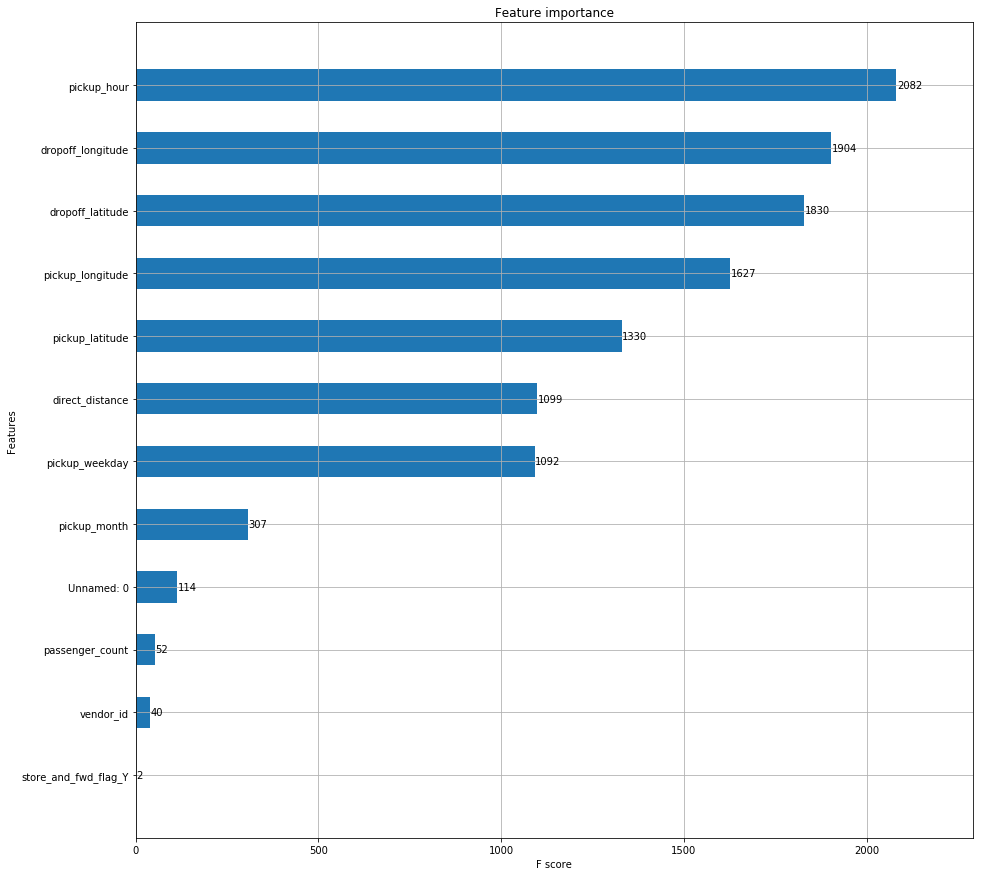

In [32]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(clf,ax = axes,height =0.5)
plt.show()

The most important features are the pickup_hour coordinates and the least important store_and_fwd_flag. 

## 2. Conclusion <a name="conclusion"></a>
***

Public transportation within New York City is relatively inexpensive, convenient and efficient. Taxis are essential part of the city. This project shows several characteristics of taxi rides, such as rush hours, GPS precision, average speed of taxis per hour, pickup and dropoff activity, etc. Through out the project data wrangling, exploratoty data analys, data cleaning and feature engineering was used to explore, analyze and make conclusions of the data. Below are some of the most important findings of the project:

- Most of the taxi trips in the data were between 3 to 50 minutes. 
- Most of the activity happened in Manhattan. As well, there was some activity in the airports J.F. Kennedy and La Guardia. 
- Daily pickups during January 2016 and June 2016 were fairly homogeneous. However, there was a drop in demand near the end of January. From January 22 to 24, 2016, there was a blizzard that hit the East Coast. According to [weather.gov](https://www.weather.gov/okx/Blizzard_Jan2016), Central Park, NY received 27.5" of snow, which is the largest snowstorm since records began in 1869.
- The busiest day during the week for taxi drivers in NYC was Friday and the slowest day was Monday. 
- The passenger count showed that most of the taxi trips carry only one passenger.
- The number of pickups per hour was higher at night with a peak between 6 and 7 PM when most people get out of work. 
- At around 5 in the morning, the taxi demand was the lowest. There is a rise of demand thoughout the day.
- Most taxis sent the taxi trip information immediately and only few of them had an issue connecting to the server and had to store it. 
- There were 2 different vendors in the data and vendor 2 had more trips in the 6 month period in 2016.
- The response variable trip_duration had no linear relationship with any of the features.
- The GPS precision of the taxis varied from 1 up to 15 decimals. According to the [Degree Precision vs. Length Table](https://en.wikipedia.org/wiki/Decimal_degrees), a coordinate with 15 decimals would be equal to 0.1 nanometer(the size of an atom!), which sounds unrealistic for a taxi. In this project, all coordinates were rounded to 5 decimals, which is worth up to 1.1 m. According to Wikipedia, it distinguishes trees from each other which makes a good precision for a big city.
- There was a really high demand after midnight on Friday, Saturday and Sunday. 
- For the 7 days of the week the demand was really low around 5 AM.
- There was high demand between 7 and 10 AM from Monday to Friday.
- Taxi demand stabilizes after 10 AM until 4 PM for all of the days in the week but still being pretty high.
- At night, demand starts to slow down except on Fridays and Saturdays.

These are just a few of the findings. For a more in depth analysis, please refer to this notebook. Just remember, even if your next [taxi driver](https://www.youtube.com/watch?v=kAd57FSAtMw) in NYC is really good at doing his job or has 5 stars on your favorite ridesharing app, traffic is just part of that NYC life unless it's 5 am.

### Results <a name="results"></a>
***

Four different supervised regression algorithms were used to model the data. Below is a table that shows the $R^2$, fitting time, prediction time and RMSLE of each algorithm.

In [34]:
d = {'RMSLE': {'Linear Regression': 0.5397, 'SVM': 0.4899, 'Random Forest': 0.3656, 'XGBoost': 0.3840},
     'R-Squared': {'Linear Regression': '55.79%', 'SVM': '50.38%', 'Random Forest': '79.95%', 'XGBoost': '78.74%'}, 
     'Fitting Time': {'Linear Regression': '16.2 s', 'SVM': '1min 44s', 'Random Forest': '2hr 39min', 'XGBoost': '~2hr'},
     'Prediction Time': {'Linear Regression': '78.2 ms', 'SVM': '117 ms', 'Random Forest': '20.4 s', 'XGBoost': '2.16 s'}}
df = pd.DataFrame(d).reindex(index = ['Linear Regression','SVM','Random Forest','XGBoost'])
df

,Fitting Time,Prediction Time,R-Squared,RMSLE
Linear Regression,16.2 s,78.2 ms,55.79%,0.5397
SVM,1min 44s,117 ms,50.38%,0.4899
Random Forest,2hr 39min,20.4 s,79.95%,0.3656
XGBoost,~2hr,2.16 s,78.74%,0.3840


Since the goal of the project was to reduce RMSLE, Random Forest gave the best result with **0.3656** making this project to the **38th place** on the [Kaggle Leaderboard](https://www.kaggle.com/c/nyc-taxi-trip-duration/leaderboard). XGBoost gave a close result; however, the time spent tuning XGBoost was already high, in fact there is a separate notebook just for [Tuning XGBoost](https://github.com/emmpew/datascience/blob/master/capstone_project/tuning_xgboost.ipynb). It would require tuning more parameters and more fitting time to make the popular XGBoost perform better than Random Forest. For this project, Random Forest was the easiest to tune and gave the best results. It needed 50 n_estimators to get the lowest RMSLE. The $R^2$ of the model was **79.95%** making this project a success. 

### Recommendations <a name="recommendations"></a>
***
This is just the beginning of predicting a NYC taxi trip. There is a lot more that can be done to improve RMSLE. 

Some ways to improve RMSLE:

- Testing for more possible hyperparameter values for Random Forest and XGBoost as well. XGBoost tends to be a more powerful algorithm; however, in this project only 5 parameters were tuned.
- More in depth data cleaning 
- More feature engineering relevant to the dataset.
- Trying another model that would give better results.